In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from VAE import VAEConv
import matplotlib.pyplot as plt
import numpy as np

## Data

In [3]:
Metadata_dir = '/content/drive/MyDrive/Project Data Science/'

In [4]:
df = pd.read_csv(Metadata_dir + "Health_VS_Calc_And_Mass.csv")
df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,Health
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training,1
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training,1
2,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test,1
3,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test,1
4,89524e5f372d9aff8ed43b4ef29c1435,0838a0b906894e0cc06c993426a2d143,5a94dd668eaa9865b907450c37db6ecc,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,1988.060059,1793.739990,2139.909912,1967.459961,training,1


Only images with no findings were used to train the VAE model. Due to computational limitations, only 1,000 images were selected.

In [5]:
df_MLO = df[df['view_position'] == 'MLO']
df_MLO = df_MLO[df_MLO['Health'] == 0]
df_train = df_MLO[df_MLO['split'] == 'training']
df_train = df_train.sample(1000)
df_train.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,Health
3522,7ca902f0527e761fc2ac5435ed008fd2,4ad3eca6b87ac56d946c738c736fb41f,984d4e548e41911497f8d889e3f23e41,L,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
19171,c2f210181aa90f2492d8f71461457a6b,b975ca89d13c420555df2d1830bbbd14,4fba0516b88167b614481b6d3ec69646,L,MLO,3580,2766,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
9781,50351444a11d3636a1be1e46eb24c3bf,933912e1bb85e04d9b255e5ed565cb27,9436de27cd5a2734cc92b30a88b23c45,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
6438,8c22bcca544675e31056b1b42eae6fc8,acb39ce3a3697509dedd97833e76ebf5,463b8658014084c18b0785b98ce1ce41,R,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0
3951,7c0fb51ff7a4027fdd4b7d7c7dca6b04,40fbdb87b9d93b3cb75fabca572ea9cf,902e4536351b278d7e48dde7e8932b0f,L,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,0


In [8]:
df_train.shape

(1000, 17)

The CustomImageDataset class is used to create the dataloader.

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'image_id' and 'series_id'.
            image_dir (str): Root directory where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image path from the dataframe
        image_id = self.dataframe.iloc[idx]['image_id']
        series_id = self.dataframe.iloc[idx]['study_id']

        # Construct the full path to the image
        img_path = os.path.join(self.image_dir, str(series_id), str(image_id) + '.png')

        # Load the image (assuming grayscale)
        image = Image.open(img_path).convert('L')  # 'L' mode for grayscale

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image

Images are resized to 128x128 and normalized with a mean of 0.5 and a standard deviation of 0.5.

In [7]:
img_size = 128
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Example resize
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (mean, std) for grayscale
])

In [8]:
image_dir = Metadata_dir + 'Processed_Images'
dataset = CustomImageDataset(dataframe=df_train, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

## Model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The Latent dimension for this project was 1024

In [10]:
latent_dim = 1024
vae = VAEConv(input_size = img_size, latent_dim = latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr = 5e-03)

In [26]:
epochs = 100
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x)  # Forward pass
        loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kld_loss += KLD.item()
        optimizer.step()  # Update the weights

    print(f"Epoch [{epoch+1}/{epochs}] Avg loss: {train_loss/len(dataloader.dataset):.3f}, Avg Recon loss: {recon_loss/len(dataloader.dataset):.3f}, Avg KLD loss: {kld_loss/len(dataloader.dataset):.3f}")


Epoch [1/100] Avg loss: 10335.000, Avg Recon loss: 10271.380, Avg KLD loss: 63.620
Epoch [2/100] Avg loss: 3060.411, Avg Recon loss: 2820.021, Avg KLD loss: 240.390
Epoch [3/100] Avg loss: 1930.246, Avg Recon loss: 1849.295, Avg KLD loss: 80.952
Epoch [4/100] Avg loss: 1698.053, Avg Recon loss: 1645.455, Avg KLD loss: 52.598
Epoch [5/100] Avg loss: 1623.984, Avg Recon loss: 1578.424, Avg KLD loss: 45.560
Epoch [6/100] Avg loss: 1589.366, Avg Recon loss: 1546.345, Avg KLD loss: 43.021
Epoch [7/100] Avg loss: 1551.836, Avg Recon loss: 1509.212, Avg KLD loss: 42.624
Epoch [8/100] Avg loss: 1465.703, Avg Recon loss: 1424.786, Avg KLD loss: 40.917
Epoch [9/100] Avg loss: 1395.535, Avg Recon loss: 1352.549, Avg KLD loss: 42.986
Epoch [10/100] Avg loss: 1310.658, Avg Recon loss: 1256.966, Avg KLD loss: 53.692
Epoch [11/100] Avg loss: 1263.100, Avg Recon loss: 1203.947, Avg KLD loss: 59.153
Epoch [12/100] Avg loss: 1236.368, Avg Recon loss: 1175.104, Avg KLD loss: 61.264
Epoch [13/100] Avg los

In [29]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies.pth')


In [30]:
extra_epochs = 50
for epoch in range(epochs, epochs + extra_epochs):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x)  # Forward pass
        loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kld_loss += KLD.item()
        optimizer.step()  # Update the weights

    print(f"Epoch [{epoch+1}/{epochs + extra_epochs}] Avg loss: {train_loss/len(dataloader.dataset):.3f}, Avg Recon loss: {recon_loss/len(dataloader.dataset):.3f}, Avg KLD loss: {kld_loss/len(dataloader.dataset):.3f}")


Epoch [101/150] Avg loss: 1048.311, Avg Recon loss: 1001.513, Avg KLD loss: 46.797
Epoch [102/150] Avg loss: 1046.508, Avg Recon loss: 999.650, Avg KLD loss: 46.859
Epoch [103/150] Avg loss: 1046.077, Avg Recon loss: 999.075, Avg KLD loss: 47.002
Epoch [104/150] Avg loss: 1047.299, Avg Recon loss: 1000.777, Avg KLD loss: 46.522
Epoch [105/150] Avg loss: 1045.941, Avg Recon loss: 1000.105, Avg KLD loss: 45.835
Epoch [106/150] Avg loss: 1045.697, Avg Recon loss: 999.898, Avg KLD loss: 45.800
Epoch [107/150] Avg loss: 1045.490, Avg Recon loss: 997.540, Avg KLD loss: 47.950
Epoch [108/150] Avg loss: 1047.022, Avg Recon loss: 1000.588, Avg KLD loss: 46.434
Epoch [109/150] Avg loss: 1046.515, Avg Recon loss: 998.988, Avg KLD loss: 47.526
Epoch [110/150] Avg loss: 1042.756, Avg Recon loss: 996.877, Avg KLD loss: 45.880
Epoch [111/150] Avg loss: 1043.682, Avg Recon loss: 997.269, Avg KLD loss: 46.413
Epoch [112/150] Avg loss: 1041.056, Avg Recon loss: 995.138, Avg KLD loss: 45.918
Epoch [113/1

In [32]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies.pth')

In [33]:
for epoch in range(150, 250):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x)  # Forward pass
        loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kld_loss += KLD.item()
        optimizer.step()  # Update the weights

    print(f"Epoch [{epoch+1}/250] Avg loss: {train_loss/len(dataloader.dataset):.3f}, Avg Recon loss: {recon_loss/len(dataloader.dataset):.3f}, Avg KLD loss: {kld_loss/len(dataloader.dataset):.3f}")


Epoch [151/250] Avg loss: 1022.791, Avg Recon loss: 977.527, Avg KLD loss: 45.264
Epoch [152/250] Avg loss: 1020.820, Avg Recon loss: 976.467, Avg KLD loss: 44.353
Epoch [153/250] Avg loss: 1022.117, Avg Recon loss: 977.587, Avg KLD loss: 44.530
Epoch [154/250] Avg loss: 1022.998, Avg Recon loss: 978.263, Avg KLD loss: 44.736
Epoch [155/250] Avg loss: 1019.271, Avg Recon loss: 973.810, Avg KLD loss: 45.461
Epoch [156/250] Avg loss: 1022.824, Avg Recon loss: 977.737, Avg KLD loss: 45.087
Epoch [157/250] Avg loss: 1019.970, Avg Recon loss: 974.454, Avg KLD loss: 45.516
Epoch [158/250] Avg loss: 1020.199, Avg Recon loss: 975.135, Avg KLD loss: 45.064
Epoch [159/250] Avg loss: 1019.656, Avg Recon loss: 975.111, Avg KLD loss: 44.545
Epoch [160/250] Avg loss: 1019.883, Avg Recon loss: 974.301, Avg KLD loss: 45.582
Epoch [161/250] Avg loss: 1017.040, Avg Recon loss: 973.410, Avg KLD loss: 43.630
Epoch [162/250] Avg loss: 1016.437, Avg Recon loss: 972.416, Avg KLD loss: 44.021
Epoch [163/250] 

In [34]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies.pth')

## Testing

Images generated by random numbers in the latent space

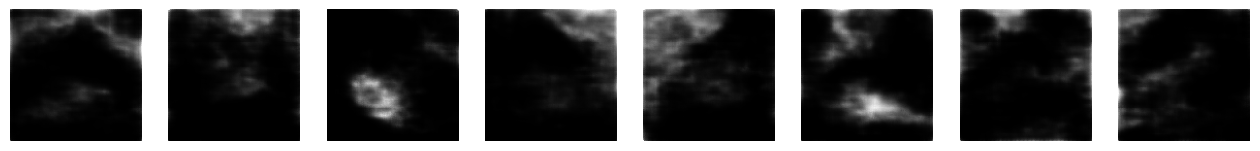

In [46]:
num_images = 8
z = torch.randn(num_images, latent_dim).to(device)
with torch.no_grad():
    generated_images = vae.Decode(z)

generated_images = generated_images.view(num_images, img_size, img_size)
generated_images = generated_images.cpu()

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
for i in range(num_images):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()

In [13]:
vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies.pth'))

<ipython-input-13-3359e1c43267>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies.pth'))


<All keys matched successfully>

In [14]:
for epoch in range(250, 350):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x)  # Forward pass
        loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kld_loss += KLD.item()
        optimizer.step()  # Update the weights

    print(f"Epoch [{epoch+1}/450] Avg loss: {train_loss/len(dataloader.dataset):.3f}, Avg Recon loss: {recon_loss/len(dataloader.dataset):.3f}, Avg KLD loss: {kld_loss/len(dataloader.dataset):.3f}")


Epoch [251/450] Avg loss: 1274.092, Avg Recon loss: 1222.860, Avg KLD loss: 51.232
Epoch [252/450] Avg loss: 1224.400, Avg Recon loss: 1172.990, Avg KLD loss: 51.411
Epoch [253/450] Avg loss: 1163.943, Avg Recon loss: 1109.072, Avg KLD loss: 54.871
Epoch [254/450] Avg loss: 1111.932, Avg Recon loss: 1060.571, Avg KLD loss: 51.361
Epoch [255/450] Avg loss: 1088.267, Avg Recon loss: 1039.276, Avg KLD loss: 48.991
Epoch [256/450] Avg loss: 1075.300, Avg Recon loss: 1027.666, Avg KLD loss: 47.634
Epoch [257/450] Avg loss: 1067.954, Avg Recon loss: 1020.854, Avg KLD loss: 47.100
Epoch [258/450] Avg loss: 1064.361, Avg Recon loss: 1018.158, Avg KLD loss: 46.204
Epoch [259/450] Avg loss: 1063.877, Avg Recon loss: 1018.343, Avg KLD loss: 45.534
Epoch [260/450] Avg loss: 1066.432, Avg Recon loss: 1021.521, Avg KLD loss: 44.911
Epoch [261/450] Avg loss: 1060.191, Avg Recon loss: 1015.820, Avg KLD loss: 44.371
Epoch [262/450] Avg loss: 1056.802, Avg Recon loss: 1012.208, Avg KLD loss: 44.593
Epoc

In [15]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies.pth')

In [16]:
for epoch in range(350, 450):
    vae.train()
    train_loss = 0
    recon_loss = 0
    kld_loss = 0
    for batch_idx, x in enumerate(dataloader):
        x = x.view(len(x), 1, img_size, img_size)
        x = x.to(device)
        optimizer.zero_grad()  # Zero the gradients
        x_hat, mu, logvar = vae(x)  # Forward pass
        loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
        loss.backward()  # Backpropagation
        train_loss += loss.item()
        recon_loss += reconstruction_loss.item()
        kld_loss += KLD.item()
        optimizer.step()  # Update the weights

    print(f"Epoch [{epoch+1}/450] Avg loss: {train_loss/len(dataloader.dataset):.3f}, Avg Recon loss: {recon_loss/len(dataloader.dataset):.3f}, Avg KLD loss: {kld_loss/len(dataloader.dataset):.3f}")


Epoch [351/450] Avg loss: 1010.164, Avg Recon loss: 967.001, Avg KLD loss: 43.163
Epoch [352/450] Avg loss: 1009.464, Avg Recon loss: 966.664, Avg KLD loss: 42.800
Epoch [353/450] Avg loss: 1009.241, Avg Recon loss: 965.739, Avg KLD loss: 43.502
Epoch [354/450] Avg loss: 1008.712, Avg Recon loss: 965.993, Avg KLD loss: 42.719
Epoch [355/450] Avg loss: 1009.033, Avg Recon loss: 965.691, Avg KLD loss: 43.342
Epoch [356/450] Avg loss: 1008.789, Avg Recon loss: 965.787, Avg KLD loss: 43.002
Epoch [357/450] Avg loss: 1008.768, Avg Recon loss: 965.314, Avg KLD loss: 43.454
Epoch [358/450] Avg loss: 1007.441, Avg Recon loss: 964.678, Avg KLD loss: 42.764
Epoch [359/450] Avg loss: 1007.326, Avg Recon loss: 964.408, Avg KLD loss: 42.919
Epoch [360/450] Avg loss: 1005.722, Avg Recon loss: 962.330, Avg KLD loss: 43.392
Epoch [361/450] Avg loss: 1007.259, Avg Recon loss: 963.900, Avg KLD loss: 43.358
Epoch [362/450] Avg loss: 1007.973, Avg Recon loss: 965.086, Avg KLD loss: 42.886
Epoch [363/450] 

In [18]:
torch.save(vae.state_dict(), 'drive/MyDrive/VAE_Anomalies.pth')

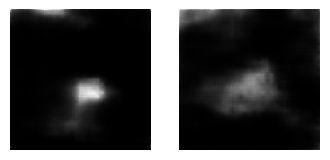

In [44]:
num_images = 2
z = torch.randn(num_images, latent_dim).to(device)
with torch.no_grad():
    generated_images = vae.Decode(z)

generated_images = generated_images.view(num_images, img_size, img_size)
generated_images = generated_images.cpu()

fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
for i in range(num_images):
    axes[i].imshow(generated_images[i], cmap='gray')
    axes[i].axis('off')

plt.show()

In [11]:
vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies.pth'))

<ipython-input-11-3359e1c43267>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load('drive/MyDrive/VAE_Anomalies.pth'))


<All keys matched successfully>

In [36]:
df_test = df_MLO[df_MLO['split'] == 'test']
df_test = df_test.sample(20)
df_test.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split,Health
1354,1e2b0ce2c5a93c643834c98803e6ac2d,0f96e90a98025d532e86eea4af730ee6,22fba1258f27256a9f1d090b0ddca9c7,L,MLO,2812,2012,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,99.932297,2001.020020,290.115997,2199.360107,test,1
718,18249f2f393ec3a4e59d4f3e9e7c6d1d,4b0e8e82fb4f9906e002255edd9d0a1a,95b5ceaec8d1517cd69cda4559c4a764,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,2549.669922,1493.219971,2796.909912,1907.339966,test,1
855,27d4dc70d6f73554e4ead70f01867167,70e28a71d0e1b828b24fda28db5bacd1,9eac03525ce74859de0f3643d611ef78,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2073.250000,1596.319946,2357.590088,1824.619995,test,1
1258,d101ecbe883dcfadae08720d3742ee34,1861fa96e1a079b35ef698e13c513cf4,2b5cec9cad04a6c5eaf1cd2ec2e7a6f2,L,MLO,2812,2012,BI-RADS 3,DENSITY B,['Mass'],BI-RADS 3,422.335999,1037.689941,534.617004,1166.890015,test,1
1371,e668b1bed3d1501af1c88ef1ecd85a8c,35c59c871f29875cde442836d002a280,673e2ee6dfb0c4165a7cfde1ba5a7f55,R,MLO,2812,2012,BI-RADS 3,DENSITY D,['Mass'],BI-RADS 3,1712.109985,1717.489990,1945.930054,1987.290039,test,1


In [37]:
image_dir = Metadata_dir + 'Processed_Images'
dataset_test = CustomImageDataset(dataframe=df_test, image_dir=image_dir, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

Testing the VAE model with images that have no findings.

In [38]:
vae.eval()
train_loss = 0
recon_loss = 0
kld_loss = 0
for batch_idx, x in enumerate(dataloader_test):
    x = x.view(len(x), 1, img_size, img_size)
    x = x.to(device)
    x_hat, mu, logvar = vae(x)  # Forward pass
    loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
    recon_loss += reconstruction_loss.item()
    print(f"Img [{batch_idx + 1}] Loss: {loss:.3f}, Recon loss: {reconstruction_loss:.3f}, Avg KLD loss: {KLD:.3f}")
print(f"Avg Reconstruction Loss: {recon_loss/df_test.shape[0]}")

Img [1] Loss: 383.395, Recon loss: 356.305, Avg KLD loss: 27.090
Img [2] Loss: 462.584, Recon loss: 428.000, Avg KLD loss: 34.584
Img [3] Loss: 370.196, Recon loss: 347.869, Avg KLD loss: 22.326
Img [4] Loss: 820.737, Recon loss: 790.698, Avg KLD loss: 30.039
Img [5] Loss: 786.412, Recon loss: 751.821, Avg KLD loss: 34.591
Img [6] Loss: 736.601, Recon loss: 690.475, Avg KLD loss: 46.126
Img [7] Loss: 35.989, Recon loss: 19.677, Avg KLD loss: 16.312
Img [8] Loss: 1396.337, Recon loss: 1342.319, Avg KLD loss: 54.018
Img [9] Loss: 253.471, Recon loss: 233.069, Avg KLD loss: 20.402
Img [10] Loss: 1767.455, Recon loss: 1703.005, Avg KLD loss: 64.450
Img [11] Loss: 2660.041, Recon loss: 2602.392, Avg KLD loss: 57.650
Img [12] Loss: 1388.666, Recon loss: 1337.341, Avg KLD loss: 51.325
Img [13] Loss: 361.715, Recon loss: 339.033, Avg KLD loss: 22.682
Img [14] Loss: 924.280, Recon loss: 891.780, Avg KLD loss: 32.501
Img [15] Loss: 1550.348, Recon loss: 1488.502, Avg KLD loss: 61.846
Img [16] Lo

In [41]:
df_MLO = df[df['view_position'] == 'MLO']
df_MLO = df_MLO[df_MLO['Health'] == 1]
df_test = df_MLO[df_MLO['split'] == 'test']
df_test = df_test.sample(20)

In [42]:
image_dir = Metadata_dir + 'Processed_Images'
dataset_test = CustomImageDataset(dataframe=df_test, image_dir=image_dir, transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=0)

Testing the VAE model with images that have findings.

In [43]:
vae.eval()
train_loss = 0
recon_loss = 0
kld_loss = 0
for batch_idx, x in enumerate(dataloader_test):
    x = x.view(len(x), 1, img_size, img_size)
    x = x.to(device)
    x_hat, mu, logvar = vae(x)  # Forward pass
    loss, reconstruction_loss, KLD = vae.ELBO(x_hat, x, mu, logvar)  # Compute the loss
    recon_loss += reconstruction_loss.item()
    print(f"Img [{batch_idx + 1}] Loss: {loss:.3f}, Recon loss: {reconstruction_loss:.3f}, Avg KLD loss: {KLD:.3f}")
print(f"Avg Reconstruction Loss: {recon_loss/df_test.shape[0]}")

Img [1] Loss: 470.587, Recon loss: 436.003, Avg KLD loss: 34.584
Img [2] Loss: 399.429, Recon loss: 368.224, Avg KLD loss: 31.205
Img [3] Loss: 1854.576, Recon loss: 1806.332, Avg KLD loss: 48.244
Img [4] Loss: 2209.584, Recon loss: 2136.880, Avg KLD loss: 72.704
Img [5] Loss: 1940.086, Recon loss: 1878.315, Avg KLD loss: 61.771
Img [6] Loss: 1310.514, Recon loss: 1254.152, Avg KLD loss: 56.362
Img [7] Loss: 1862.849, Recon loss: 1809.250, Avg KLD loss: 53.599
Img [8] Loss: 272.332, Recon loss: 247.554, Avg KLD loss: 24.778
Img [9] Loss: 957.484, Recon loss: 911.779, Avg KLD loss: 45.705
Img [10] Loss: 500.648, Recon loss: 474.429, Avg KLD loss: 26.219
Img [11] Loss: 942.065, Recon loss: 901.876, Avg KLD loss: 40.189
Img [12] Loss: 1986.196, Recon loss: 1929.810, Avg KLD loss: 56.386
Img [13] Loss: 1010.438, Recon loss: 964.934, Avg KLD loss: 45.505
Img [14] Loss: 707.696, Recon loss: 680.079, Avg KLD loss: 27.617
Img [15] Loss: 541.914, Recon loss: 513.526, Avg KLD loss: 28.388
Img [1